In [268]:
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from collections import defaultdict
from frites import set_mpl_style
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
import warnings
import io
import xarray as xr
set_mpl_style()

In [269]:
def process_events(rows, blocks, colnames):
    
    # If no data, create empty dataframe w/ all cols and types
    if len(rows) == 0:
        rows = ["", ""]
        blocks = []
    # Parse data, dropping useless first column
    if len(rows) == 1:
        list(rows).append("")
    colnames = ['type'] + colnames # first col is event type, which we drop later
    coltypes = get_coltypes(colnames)
    df = pd.read_csv(io.StringIO('\n'.join(rows)), delimiter='\s+', header=None, names=colnames, na_values='.', index_col=False)
    df = df.iloc[:, 1:] # drop the first column
    # Move eye column to end & make factor, append block numbers to beginning of data frame
    if 'eye' in colnames:
        df = df.iloc[:, [1] + list(range(2, df.shape[1])) + [0]]
        df['eye'] = pd.Categorical(df['eye'], categories=["L", "R"], ordered=False)
    df.insert(loc=0, column='trial', value=blocks)
    return df




def process_saccades(saccades, blocks, info):
    sacc_df = process_events(saccades, blocks, get_sacc_header(info))
    # Set amplitudes for any saccades missing start/end coords to NAs because they're wonky
    ampl_cols = [col for col in sacc_df.columns if re.search(r'ampl\d*$', col)]
    partial = sacc_df['sxp'].isna() | sacc_df['exp'].isna()
    if any(partial):
        sacc_df.loc[partial, ampl_cols] = pd.NA
    return sacc_df



def process_fixations(fixations, blocks, info):
    return process_events(fixations, blocks, get_fix_header(info))


def process_blinks(blinks, blocks):
    return process_events(blinks, blocks, ['eye', 'stime', 'etime', 'dur'])


def process_messages(msgs, blocks):
    # Process messages from tracker
    msg_mat = [msg.split(' ', 1) for msg in msgs]
    msg_mat = [[msg[0][4:], msg[1]] for msg in msg_mat]
    msg_df = pd.DataFrame(msg_mat, columns=['time', 'text'])
    msg_df['time'] = pd.to_numeric(msg_df['time'])
    
    # Append trial numbers to beginning of data frame
    msg_df.insert(0, 'trial', blocks)
    
    return msg_df


def process_input(input_data, blocks):
    return process_events(input_data, blocks, ['time', 'value'])


def process_buttons(button, blocks):
    return process_events(button, blocks, ['time', 'button', 'state'])

In [270]:
import re

def from_header(header, field):
    pattern = r"\*\* {}\s*: (.*)".format(re.escape(field))
    matches = [re.findall(pattern, line) for line in header]
    matches = [match for match in matches if match]
    return matches[0][0] if matches else None



def get_resolution(nonsample):
    res = [None, None]
    for pattern in ["DISPLAY_COORDS", "GAZE_COORDS", "RESOLUTION"]:
        display_xy = [x for x in nonsample if pattern in x]
        if len(display_xy) == 0:
            continue
        display_xy = re.sub(f".* {pattern}\\D+(.*)", "\\1", display_xy[0])
        display_xy = [int(x) for x in re.split("\\s+", display_xy)]
        res = [display_xy[2] - display_xy[0] + 1, display_xy[3] - display_xy[1] + 1]
        break
    return res


def get_resolution(nonsample):
    res = [None, None]
    for pattern in ["DISPLAY_COORDS", "GAZE_COORDS", "RESOLUTION"]:
        display_xy = [s for s in nonsample if pattern in s]
        if len(display_xy) == 0:
            continue
        display_xy = re.sub(f".* {pattern}\\D+(.*)", "\\1", display_xy[0])
        try:
            display_xy = [int(float(s)) for s in display_xy.split()]
        except ValueError:
            continue
        res = [display_xy[2] - display_xy[0] + 1, display_xy[3] - display_xy[1] + 1]
        break
    return res

In [271]:
def get_mount(mount_str):
    # Older EyeLink 1000s may be missing "R" in table mount names, we add one if needed
    if re.search("TABLE$", mount_str):
        mount_str = mount_str + "R"
    
    mounts = {
        "MTABLER": "Desktop / Monocular / Head Stabilized",
        "BTABLER": "Desktop / Binocular / Head Stabilized",
        "RTABLER": "Desktop / Monocular / Remote",
        "RBTABLER": "Desktop / Binocular / Remote",
        "AMTABLER": "Arm Mount / Monocular / Head Stabilized",
        "ARTABLER": "Arm Mount / Monocular / Remote",
        "TOWER": "Tower Mount / Monocular / Head Stabilized",
        "BTOWER": "Tower Mount / Binocular / Head Stabilized",
        "MPRIM": "Primate Mount / Monocular / Head Stabilized",
        "BPRIM": "Primate Mount / Binocular / Head Stabilized",
        "MLRR": "Long-Range Mount / Monocular / Head Stabilized",
        "BLRR": "Long-Range Mount / Binocular / Head Stabilized"
    }
    
    return mounts[mount_str] if mount_str in mounts else None


def get_raw_header(info):
    eyev = ["xp", "yp", "ps"]
    
    if not info["mono"]:
        eyev = [f"{e}{s}" for s in ["l", "r"] for e in eyev]
    
    if info["velocity"]:
        if info["mono"]:
            eyev += ["xv", "yv"]
        else:
            eyev += [f"{e}{s}" for s in ["vl", "vr"] for e in ["x", "y"]]
    
    if info["resolution"]:
        eyev += ["xr", "yr"]
    
    if info["input"]:
        eyev += ["input"]
    
    if info["buttons"]:
        eyev += ["buttons"]
    
    if info["tracking"]:
        eyev += ["cr.info"]
    
    if info["htarg"]:
        eyev += ["tx", "ty", "td", "remote.info"]
    
    return ["time"] + eyev

    

def get_event_header(info, xy_cols):
    base = ["eye", "stime", "etime", "dur"]
    
    if info["event.dtype"] == "HREF":
        xy_cols = [f"href.{xy}" for xy in xy_cols] + xy_cols
        
    if info["resolution"]:
        xy_cols += ["xr", "yr"]
        
    return base + xy_cols
    

def get_sacc_header(info):
    return get_event_header(info, ["sxp", "syp", "exp", "eyp", "ampl", "pv"])
    

def get_fix_header(info):
    return get_event_header(info, ["axp", "ayp", "aps"])
    
    


In [272]:
def get_model(header):
    version_str = from_header(header, "VERSION")
    version_str2 = [x for x in header if re.search("\\*\\* EYELINK II", x)]
    if version_str is None:
        model = "Unknown"
        ver_num = "Unknown"
    elif version_str != 'EYELINK II 1':
        model = "EyeLink I"
        ver_num = re.search(r'(\d+.\d+)', version_str).group(1)
    else:
        ver_num = re.search(r'v(\d+.\d+)', version_str2[0]).group(1)
        model = ('EyeLink II' if float(ver_num) < 2.4 else
                 'EyeLink 1000' if float(ver_num) < 5 else
                 'EyeLink 1000 Plus' if float(ver_num) < 6 else
                 'EyeLink Portable Duo')
    return [model, ver_num]

In [273]:
def get_coltypes(colnames, float_time=True):
    chr_cols=["type", "eye", "cr.info", "remote.info"]
    int_cols=["button", "state", "value"]
    time_cols=["time", "stime", "etime", "dur"]
    if not float_time:
        int_cols += time_cols
    
    coltypes = ['str' if col in chr_cols else 'int64' if col in int_cols else 'float64' for col in colnames]
    
    return coltypes


def get_htarg_regex(binocular):
    htarg_errs = "MANCFTBLRTBLRTBLR" if binocular else "MANCFTBLRTBLR"
    htarg_errs = list(htarg_errs)
    htarg_regex = "(" + "|".join(htarg_errs + ["\\."]) + ")"
    
    return htarg_regex


def is_float(string):
    return bool(re.search("\\.", string))

In [274]:
def get_info(nonsample, firstcol):
    header = [f for f in nonsample if f.startswith ("**")]
    info = {}
    
    # Get date/time of recording from file
    datetime.strptime(from_header(header, "DATE"), "%a %b %d %H:%M:%S %Y")
    # Get tracker model/version info
    version_info = get_model(header)
    info["model"] = version_info[0]
    info["version"] = version_info[1]

    # Get tracker mount info
    elclcfg = [line for line in nonsample if "ELCLCFG" in line]
    if len(elclcfg) > 0:
        info["mount"] = get_mount(re.findall(r"ELCLCFG\s+(.*)", elclcfg[0])[0])

    # Get display size from file
    screen_res = get_resolution(nonsample)
    info["screen.x"] = screen_res[0]
    info["screen.y"] = screen_res[1]

    #Get pupil size data type (area or diameter)
    pupil_config = [line for i,line in enumerate(nonsample) if firstcol[i] == "PUPIL"]
    if len(pupil_config) > 0:
        info["pupil.dtype"] = pupil_config[-1].split()[1]

    # Find the samples and events config lines in the non-sample input, get data types
    events_config = [line for i,line in enumerate(nonsample) if firstcol[i] == "EVENTS"]
    samples_config = [line for i,line in enumerate(nonsample) if firstcol[i]== "SAMPLES"]
    
    # Find the samples and events config lines in the non-sample input, get data types
    events_config = [line for i,line in enumerate(nonsample) if firstcol[i] == "EVENTS"]
    samples_config = [line for i,line in enumerate(nonsample) if firstcol[i] == "SAMPLES"]
    if len(events_config) > 0:
        info["event.dtype"] = events_config[-1].split()[1]
    if len(samples_config) > 0:
        info["sample.dtype"] = samples_config[-1].split()[1]
    
   
        
    
    # Get last config line in file (preferring sample config) and extract remaining info
    config = events_config + samples_config[-1:]
    config = config[-1] if len(config) > 0 else ""
    if config:
        info["sample.rate"] = float(re.findall(r"RATE\s+([0-9]+\.[0-9]+)", config)[0]) if "RATE" in config else None
        info["tracking"] = "\tTRACKING" in config
        info["cr"] = "\tCR" in config
        info["filter.level"] = int(re.findall(r"FILTER\s+([0-9]+)", config)[0]) if "FILTER" in config else None
        info["velocity"] = "\tVEL" in config
        info["resolution"] = "\tRES" in config
        info["htarg"] = "\tHTARG" in config
        info["input"] = "\tINPUT" in config
        info["buttons"] = "\tBUTTONS" in config
        info["left"] = "\tLEFT" in config
        info["right"] = "\tRIGHT" in config
        info["mono"] = not(info["right"] & info["left"])



    return info



In [275]:
def process_raw(raw, blocks, info):
    if len(raw) == 0:
        # If no sample data in file, create empty raw DataFrame w/ all applicable columns
        raw = ["", ""]
        blocks = pd.Series([], dtype=int)
        colnames = get_raw_header(info)
        coltypes = get_coltypes(colnames, float_time=False)
    else:
        # Determine if timestamps stored as floats (edf2asc option -ftime, useful for 2000 Hz)
        float_time = is_float(re.split(r'\s+', raw[0])[0])
        # Generate column names and types based in info in header
        colnames = get_raw_header(info)
        coltypes = get_coltypes(colnames, float_time)
        # Discard any rows with too many or too few columns (usually rows where eye is missing)
        row_length = [len(re.split(r'\t', r)) for r in raw]
        med_length = np.median(row_length)
        raw = [r for r, l in zip(raw, row_length) if l == med_length]
        blocks = blocks[row_length == med_length]
        # Verify that generated columns match up with actual maximum row length
        length_diff = med_length - len(colnames)
        if length_diff > 0:
            warnings.warn("Unknown columns in raw data. Assuming first one is time, please check the others")
            colnames = ["time"] + [f"X{i+1}" for i in range(med_length-1)]
            coltypes = "i" + "?"*(med_length-1)
    # Process raw sample data using pandas
    if len(raw) == 1:
        raw.append("")
   
    raw_df = pd.read_csv(io.StringIO("".join(raw)), sep='\t', header=None, names=colnames, na_values=np.nan, low_memory=False)

    if info["tracking"] and not info["cr"]:
        raw_df = raw_df.drop(columns=["cr.info"]) # Drop CR column when not actually used
    # Append block numbers to beginning of DataFrame
    raw_df.insert(0, "trial", blocks)
    # Replace missing pupil data (zeros) with NaNs
    if "X1" not in raw_df.columns:
        if info["mono"]:
            raw_df.loc[raw_df["ps"] == 0, "ps"] = np.nan
        else:
            raw_df.loc[raw_df["psl"] == 0, "psl"] = np.nan
            raw_df.loc[raw_df["psr"] == 0, "psr"] = np.nan
    return raw_df


In [276]:
def read_asc(fname, samples=True, events=True, parse_all=False):
    with open(fname, 'r') as f:
        inp = f.readlines()

    # Convert to ASCII
    inp = [line.encode('ascii', 'ignore').decode() for line in inp]
    
    # Get strings prior to first tab for each line for faster string matching
    inp_first = [re.split(r'\s', s)[0] for s in inp]
    
    #Get the Trial info for each trial: 
    bias = [s.split()[4]for s in inp if len(s.split()) > 4 and s.split()[2] == 'Trialinfo:']
    direct = [s.split()[5]for s in inp if len(s.split()) > 4 and s.split()[2] == 'Trialinfo:']
    # Check if any actual data recorded in file
    starts = [i for i,x in enumerate(inp_first) if x == "START"]
    if not starts:
        raise ValueError("No samples or events found in .asc file.")

    # Read metadata from file before processing
    is_raw = [bool(re.match('^[0-9]', line)) for line in inp_first]
    
    info = get_info([line for line, raw in zip(inp, is_raw) if not raw],
                    [first for first, raw in zip(inp_first, is_raw) if not raw])

    # Do some extra processing/sanitizing if there's HTARG info in the file
    if info['htarg']:
        inp, info = handle_htarg(inp, info, is_raw)

    # Find blocks and mark lines between block ENDs and next block STARTs
    dividers = starts + [len(inp)]
    block = np.cumsum([x == "START" for x in inp_first])
    block = block.astype(float)

    for i in range(1, len(dividers)):
        start = dividers[i-1]
        end = dividers[i]
        endline = [j for j, x in enumerate(inp_first[start:end]) if x == "END"]
        if endline and endline[-1] < end-start:
             block[endline[0]+start:end] += 0.5

    # Unless parsing all input, drop any lines not within a block
    block[:dividers[0]+1] += 0.5
    if not parse_all:
        in_block = np.floor(block) == block
        inp = [line for line, block_match in zip(inp, in_block) if block_match]
        inp_first = [first for first, block_match in zip(inp_first, in_block) if block_match]
        is_raw = [raw for raw, block_match in zip(is_raw, in_block) if block_match]
        block = block[in_block]
    
    block=np.array(block)

    # Initialize dictionary of data output and process different data types
    out = {}
    if samples:
        out['raw'] = process_raw([line for line, raw in zip(inp, is_raw) if raw],
                                 block[is_raw], info)
    if events:
        is_sacc = np.array(inp_first) == "ESACC"
        out['sacc'] = process_saccades(np.array(inp)[is_sacc], np.array(block)[is_sacc], info)

        is_fix = np.array(inp_first) == "EFIX"
        out['fix'] = process_fixations(np.array(inp)[is_fix], np.array(block)[is_fix], info)

        is_blink = np.array(inp_first) == "EBLINK"
        out['blinks'] = process_blinks(np.array(inp)[is_blink], np.array(block)[is_blink])

        is_msg = np.array(inp_first) == "MSG"
        out['msg'] = process_messages(np.array(inp)[is_msg], np.array(block)[is_msg])

        is_input = np.array(inp_first) == "INPUT"
        out['input'] = process_input(np.array(inp)[is_input], np.array(block)[is_input])

        is_button = np.array(inp_first) == "BUTTON"
        out['button'] = process_buttons(np.array(inp)[is_button], np.array(block)[is_button])

    
    info['tracking'] = None  # needed for parsing, but otherwise redundant with CR
    
    out['info'] = info

    return out,np.array(bias,dtype='int'), np.array(direct,dtype='int')%2


In [277]:
path='/Users/hamzahalloway/Nextcloud/Shared/HAMZA_PhD/Data/Probant_DevAsd/DATA/Controles/'
from os import listdir
categories = np.sort([f for f in listdir(path)])
namesCat=[]
for cat in categories:
    namesCat.append(np.sort([f for f in listdir(path+cat)]))


In [278]:
allFiles=[]

for nameCat,cat in zip(namesCat,categories):
    filesCat=[]
    for name in nameCat:
        files=np.sort([f for f in listdir(path+cat+'/'+name)])
        filesCat.append(files)
    allFiles.append(filesCat)


In [279]:
allPaths=[]
for cat,names,conditions in zip(categories,namesCat,allFiles):
    catPaths=[]
    for name,namecond in zip(names,conditions):
        for condition in namecond:
            catPaths.append(path+cat+'/'+name+'/'+condition)
    allPaths.append(catPaths)

## Going through all the Adultes 

In [280]:
meanPosBias=[]
stdPosBias=[]

meanPosNoBias=[]
stdPosNoBias=[]

meanVeloBias=[]
stdVeloBias=[]

meanVeloNoBias=[]
stdVeloNoBias=[]

subjects=[]

Probas=[]

for f in allPaths[1]:
    data,bias,direct=read_asc(f)
    
    df=data["raw"]
    
    #Checking if the experiment was binorcular or monocular
    mono=data["info"]["mono"]
    #Putting all the data in the right format
    df['trial'] = pd.to_numeric(df['trial'], errors='coerce')
    df['time'] = pd.to_numeric(df['time'], errors='coerce')
    if not mono:
        df['xpl'] = pd.to_numeric(df['xpl'], errors='coerce')
        df['ypl'] = pd.to_numeric(df['ypl'], errors='coerce')
        df['psl'] = pd.to_numeric(df['psl'], errors='coerce')
        df['xpr'] = pd.to_numeric(df['xpr'], errors='coerce')
        df['ypr'] = pd.to_numeric(df['ypr'], errors='coerce')
        df['psr'] = pd.to_numeric(df['psr'], errors='coerce')
    else:
        df['xp'] = pd.to_numeric(df['xp'], errors='coerce')
        df['ypl'] = pd.to_numeric(df['yp'], errors='coerce')
        df['ps'] = pd.to_numeric(df['ps'], errors='coerce')

    df['input'] = pd.to_numeric(df['input'], errors='coerce')
    
    #Messages from eyelink:
    MSG=data["msg"]
    t0=MSG.loc[MSG.text=='StimulusOff\n','time']
    Zero=MSG.loc[MSG.text=='TargetOn\n',["trial","time"]]
    #resetting the time
    for i in range (len(Zero)):
        df.loc[df['trial'] == i+1, 'time'] = df.loc[df['trial'] == i+1, 'time'] - Zero.time.values[i]
    
    #Getting the saccades:
    Sacc=data["sacc"]
    #Resetting the saccades
    for t in Zero.trial:
        Sacc.loc[Sacc.trial==t,["stime","etime"]]=Sacc.loc[Sacc.trial==t,["stime","etime"]].values-Zero.loc[Zero.trial==t,'time'].values
  
    for t in Sacc.trial.unique():
    
        start=Sacc.loc[(Sacc.trial==t) & (Sacc.eye=="R"),"stime"]
        end=Sacc.loc[(Sacc.trial==t) & (Sacc.eye=="R"),"etime"]

    for i in range(len(start)):
        if not mono:
            df.loc[(df.trial==t) & (df.time>=start.iloc[i]-20) & (df.time<=end.iloc[i]+20),'xpr']=np.nan
        else:
             df.loc[(df.trial==t) & (df.time>=start.iloc[i]-20) & (df.time<=end.iloc[i]+20),'xp']=np.nan
    
    
    
    #Getting the probability from the name of the file
        proba=int(f[-6:-4])/100#probability
        if proba==0:
            proba=1
    
    #first porbability switch
    first_bias=np.where(bias==1)[0][0]+1
    
    
    if not mono:
        # Select the desired values
        selected_values = df.xpr[(df.time >= 80) & (df.time <= 120) & (df.trial < first_bias)]

        # Reshape into a 2D matrix
        time_dim = 41
        
        trial_dim = len(selected_values) // time_dim
        
        pos_non_bias = np.array(selected_values[:time_dim * trial_dim]).reshape(trial_dim, time_dim)
        
        velo_non_bias=np.gradient(pos_non_bias,axis=1)*1000/30
        
        
        # Select the desired values
        selected_values = df.xpr[(df.time >= 80) & (df.time <= 120) & (df.trial >= first_bias)]

        # Reshape into a 2D matrix
        time_dim  = 41
        
        trial_dim = len(selected_values) // time_dim
        
        pos_bias  = np.array(selected_values[:time_dim * trial_dim]).reshape(trial_dim, time_dim)
        
        #Computing the velocity in deg/s 
        velo_bias = np.gradient(pos_bias,axis=1)*1000/30
        
        
    else:
        # Select the desired values
        selected_values = df.xp[(df.time >= 80) & (df.time <= 120) & (df.trial < first_bias)]

        # Reshape into a 2D matrix
        time_dim = 41
        
        trial_dim = len(selected_values) // time_dim
        
        pos_non_bias = np.array(selected_values[:time_dim * trial_dim]).reshape(trial_dim, time_dim)
        
        velo_non_bias=np.gradient(pos_non_bias,axis=1)*1000/30
        
        
        # Select the desired values
        selected_values = df.xp[(df.time >= 80) & (df.time <= 120) & (df.trial >= first_bias)]

        # Reshape into a 2D matrix
        time_dim  = 41
        
        trial_dim = len(selected_values) // time_dim
        
        pos_bias  = np.array(selected_values[:time_dim * trial_dim]).reshape(trial_dim, time_dim)
        
        velo_bias = np.gradient(pos_bias,axis=1)*1000/30
 
    #mean pos on bias and non bias trials for time window 80,120
    meanPosBias.append(np.mean(pos_bias,axis=1))
    meanPosNoBias.append(np.mean(pos_non_bias,axis=1))
    
    #variance of pos on bias and non bias trials
    stdPosBias.append(np.std(pos_bias,axis=1))
    stdPosNoBias.append(np.std(pos_non_bias,axis=1))
    
    #mean of velocity on bias and non bias trials
    meanVeloBias.append(np.mean(velo_bias,axis=1))
    meanVeloNoBias.append(np.mean(velo_non_bias,axis=1))
    
    #var of velocity on bias and non bias trials
    stdVeloBias.append(np.std(velo_bias,axis=1))
    stdVeloNoBias.append(np.std(velo_non_bias,axis=1))
    
    #subjects.append(name)
    
    Probas.append(proba)
    
    


In [290]:
dfBias= pd.DataFrame({"meanPos": meanPosBias,"stdPos": stdPosBias, "meanVelo": meanVeloBias,"stdVelo": stdVeloBias,"proba": Probas})

In [321]:
subjects=[]
for name,file in zip (namesCat[1],allFiles[1]):
    for i in range(len(file)):
        subjects.append(name)
dfBias["name"]=subjects

In [322]:
dfBias

,meanPos,stdPos,meanVelo,stdVelo,proba,name,meanPos_mean,stdPos_mean,meanVelo_mean,stdVelo_mean
0,"[824.1634146341463, 850.3292682926827, 868.341...","[0.457328455142914, 0.29897703838665557, 0.472...","[-1.5853658536586197, -0.7317073170732447, -0....","[5.218157005641753, 4.4940306762657, 5.3495070...",0.9,ADGO,891.208018,0.979555,1.923543,5.550948
1,"[877.1999999999999, 896.9073170731708, 881.556...","[0.2641137966123244, 1.0768948685926518, 0.344...","[-0.5691056910569475, 3.333333333333306, -0.77...","[3.7828910972786667, 5.19276127389795, 4.16622...",0.7,ADGO,907.878541,7.906383,-14.714701,52.184691
2,"[856.3365853658537, 874.360975609756, 853.5780...","[0.7007856558146758, 0.6040021195167504, 0.690...","[-1.8292682926829733, 1.4634146341463972, 0.77...","[6.146416741484274, 4.8163441525811495, 4.8149...",1.0,ADGO,886.099233,6.492971,-2.119241,47.493988
3,"[875.2829268292683, 854.7341463414635, 877.321...","[1.3582453600365065, 0.6422558399501145, 0.369...","[-2.7235772357722836, 1.0975609756097746, -0.4...","[6.287554894629358, 5.492169297322711, 3.88248...",0.9,ANAM,879.162273,1.197398,2.363778,6.153945
4,"[907.4195121951219, 908.3170731707318, 902.941...","[1.004191098370423, 0.8525149134020362, 0.4558...","[-0.5691056910569015, 1.382113821138202, 0.162...","[5.455036161696285, 6.459194818224758, 4.57998...",0.7,ANAM,908.941387,0.974468,1.668784,5.779261
...,...,...,...,...,...,...,...,...,...,...
90,"[785.0829268292683, 795.2999999999998, 786.675...","[0.18333288266309086, 0.46852128566581347, 1.5...","[0.040650406504074255, -0.1219512195121767, -3...","[2.7420198299253578, 6.45382015295796, 5.00511...",0.9,PICI,800.793994,1.434290,-0.239094,7.497884
91,"[680.3, 603.3853658536586, 681.3341463414636, ...","[1.2267347100251462, 0.9821730451103561, 0.266...","[-3.2520325203252036, -2.1138211382114007, 0.4...","[4.713344078255524, 4.049564034280472, 3.29293...",1.0,PICI,692.219311,1.842534,-1.108003,8.511248
92,"[665.8219512195122, 705.0439024390244, 675.765...","[0.2225267263991527, 0.5508524571119346, 0.693...","[0.08130081300805614, 0.7317073170731521, 1.50...","[2.3556200316178066, 3.7907457648374683, 3.075...",0.7,PICI,674.296755,1.082419,1.336242,6.759532
93,"[857.1000000000001, 856.5463414634145, 848.448...","[0.3675893785455584, 0.8625253791884601, 0.463...","[0.8943089430894495, 1.9918699186991782, 0.569...","[4.325783933145761, 4.511645758691083, 5.93106...",0.9,THLA,873.138334,1.368950,2.966329,5.249559


In [294]:
# Calculate the mean for 'meanPos'
dfBias['meanPos_mean'] = dfBias['meanPos'].apply(lambda x: pd.Series(x).mean())

# Calculate the mean for 'stdPos'
dfBias['stdPos_mean'] = dfBias['stdPos'].apply(lambda x: pd.Series(x).mean())

In [295]:
# Calculate the mean for 'meanPos'
dfBias['meanVelo_mean'] = dfBias['meanVelo'].apply(lambda x: pd.Series(x).mean())

# Calculate the mean for 'stdPos'
dfBias['stdVelo_mean'] = dfBias['stdVelo'].apply(lambda x: pd.Series(x).mean())

<AxesSubplot: xlabel='proba', ylabel='meanPos_mean'>

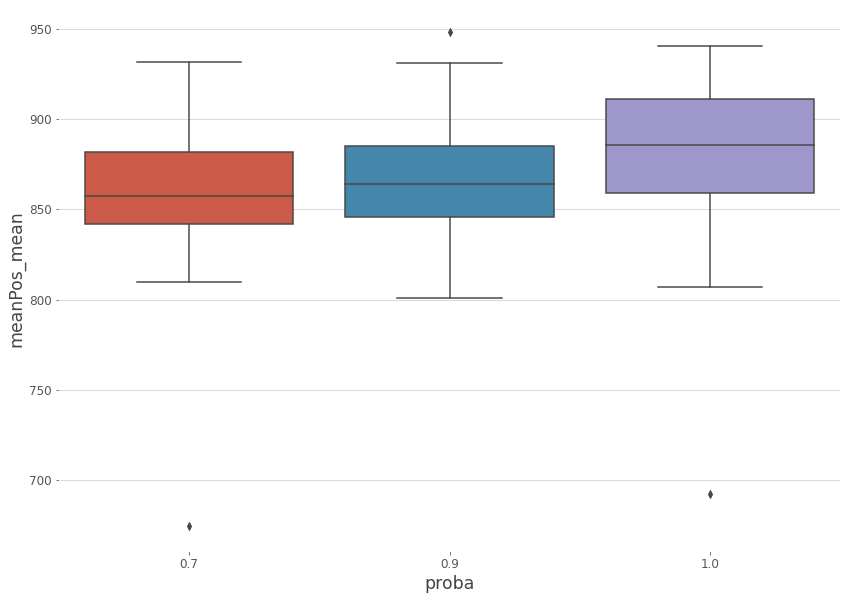

In [296]:
sns.boxplot(data=dfBias,x='proba',y='meanPos_mean')

<AxesSubplot: xlabel='stdPos_mean', ylabel='meanPos_mean'>

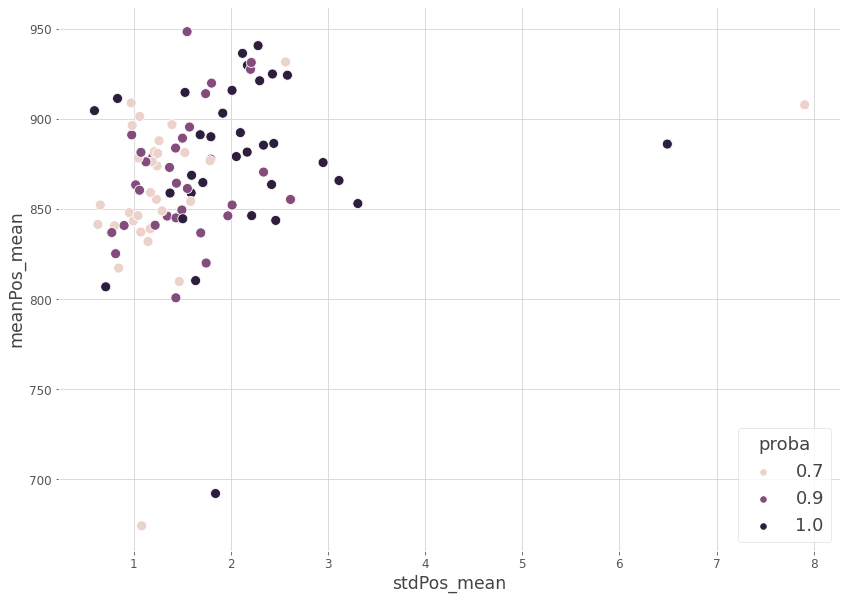

In [297]:
sns.scatterplot(data=dfBias,x='stdPos_mean' ,y='meanPos_mean',s=100,hue='proba')

<AxesSubplot: xlabel='stdVelo_mean', ylabel='meanVelo_mean'>

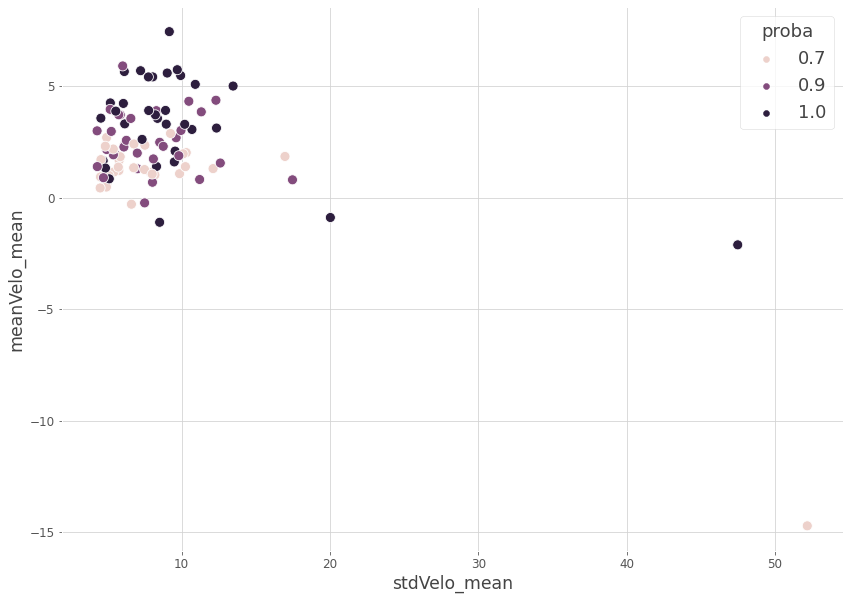

In [298]:
sns.scatterplot(data=dfBias,x='stdVelo_mean' ,y='meanVelo_mean',s=100,hue='proba')

<AxesSubplot: xlabel='proba', ylabel='meanVelo_mean'>

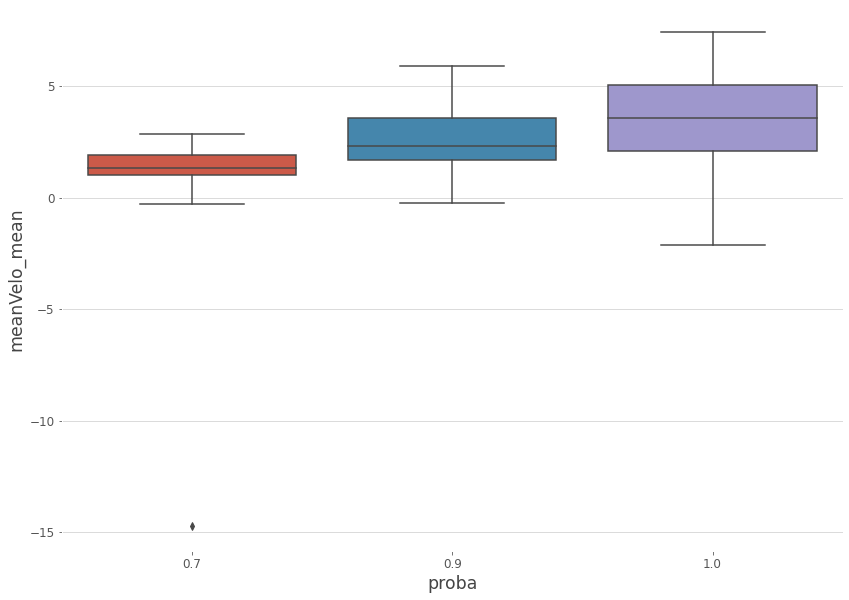

In [299]:
sns.boxplot(data=dfBias,x='proba',y='meanVelo_mean')

In [312]:
dfNoBias= pd.DataFrame({"meanPos": meanPosNoBias,"stdPos": stdPosNoBias, "meanVelo": meanVeloNoBias,"stdVelo": stdVeloNoBias,"proba": [.5]*len(meanPosNoBias)})

In [313]:
dfNoBias["name"]=subjects

In [314]:
dfNoBias

,meanPos,stdPos,meanVelo,stdVelo,proba,name
0,"[848.009756097561, 859.3073170731709, 867.1121...","[0.3448611442367416, 1.6423347812218245, 0.364...","[1.0162601626015337, 0.16260162601615838, -0.4...","[3.3308537277431247, 10.875028443091635, 5.657...",0.5,ADGO
1,"[nan, 845.9243902439023, 864.2707317073172, 86...","[nan, 1.082630150527706, 0.3890224787780901, 0...","[nan, -2.3170731707316796, 0.7723577235771805,...","[nan, 5.383378624749573, 3.755710394293203, 3....",0.5,ADGO
2,"[830.2146341463414, 1072.3634146341465, 740.36...","[0.5554874702148856, 360.53586524079077, 0.551...","[0.975609756097598, -668.2520325203252, 0.5284...","[4.77084088302887, 1917.2066030300002, 2.88531...",0.5,ADGO
3,"[832.0707317073169, 860.9512195121949, 876.509...","[0.25494514229537985, 0.702997745276021, 0.447...","[0.12195121951226903, -0.08130081300810224, -0...","[4.902715412398035, 7.747289232293073, 4.91180...",0.5,ANAM
4,"[843.1512195121952, 859.3609756097562, 868.475...","[0.8465487902380028, 1.7439621344038327, 1.291...","[-1.6666666666666299, 2.560975609756125, 2.967...","[6.48115885117765, 13.915626322905952, 5.36616...",0.5,ANAM
...,...,...,...,...,...,...
90,"[840.7268292682927, 808.0341463414635, 802.643...","[0.3147003144641807, 0.5403746469552181, 0.524...","[-0.8130081300812543, 0.9349593495936163, -1.0...","[6.808670058838541, 6.896925795740489, 5.57785...",0.5,PICI
91,"[701.9585365853659, 721.6146341463414, 692.953...","[0.9525256823260988, 0.43368021016377306, 0.63...","[-2.1138211382114007, 1.01626016260158, 1.7886...","[3.492624638050606, 3.3104509059355247, 4.0389...",0.5,PICI
92,"[676.3097560975609, 686.2780487804879, 670.960...","[0.4610723862796985, 0.4960882076965608, 0.465...","[-1.2195121951219512, -0.20325203252027899, 0....","[3.982080291466362, 4.802256723779698, 2.08548...",0.5,PICI
93,"[856.0658536585365, 857.3170731707318, 846.673...","[0.230174648534714, 0.615214592354617, 0.36427...","[7.582010899879118e-17, -1.5853658536585273, 0...","[3.4334556770369766, 3.3119480572470326, 5.195...",0.5,THLA


In [315]:
# Calculate the mean for 'meanPos'
dfNoBias['meanPos_mean'] = dfNoBias['meanPos'].apply(lambda x: pd.Series(x).mean())

# Calculate the mean for 'stdPos'
dfNoBias['stdPos_mean'] = dfNoBias['stdPos'].apply(lambda x: pd.Series(x).mean())

# Calculate the mean for 'meanPos'
dfNoBias['meanVelo_mean'] = dfNoBias['meanVelo'].apply(lambda x: pd.Series(x).mean())

# Calculate the mean for 'stdPos'
dfNoBias['stdVelo_mean'] = dfNoBias['stdVelo'].apply(lambda x: pd.Series(x).mean())

<AxesSubplot: xlabel='proba', ylabel='meanPos_mean'>

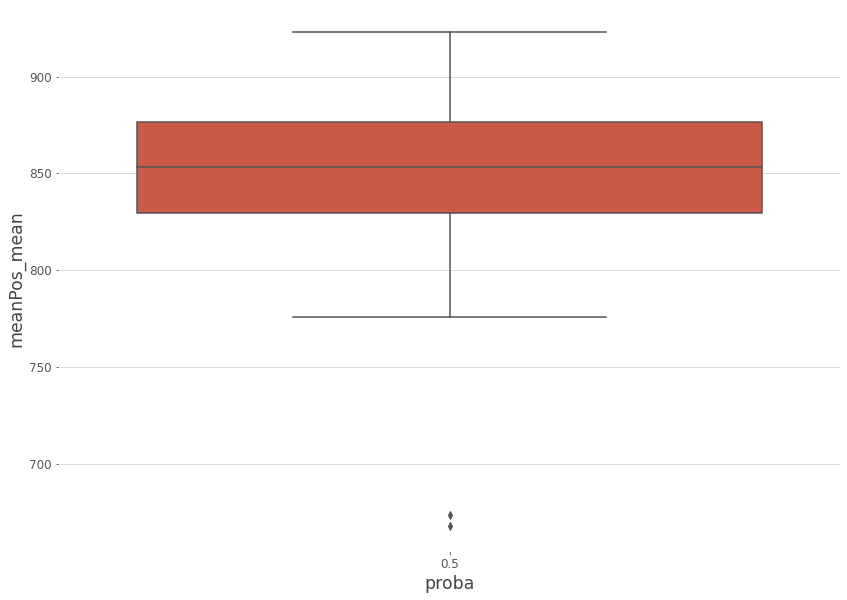

In [316]:
sns.boxplot(data=dfNoBias,x='proba',y='meanPos_mean')

In [317]:
df=pd.concat([dfBias,dfNoBias],axis=0)

In [318]:
df

,meanPos,stdPos,meanVelo,stdVelo,proba,name,meanPos_mean,stdPos_mean,meanVelo_mean,stdVelo_mean
0,"[824.1634146341463, 850.3292682926827, 868.341...","[0.457328455142914, 0.29897703838665557, 0.472...","[-1.5853658536586197, -0.7317073170732447, -0....","[5.218157005641753, 4.4940306762657, 5.3495070...",0.9,ADGO,891.208018,0.979555,1.923543,5.550948
1,"[877.1999999999999, 896.9073170731708, 881.556...","[0.2641137966123244, 1.0768948685926518, 0.344...","[-0.5691056910569475, 3.333333333333306, -0.77...","[3.7828910972786667, 5.19276127389795, 4.16622...",0.7,ADGO,907.878541,7.906383,-14.714701,52.184691
2,"[856.3365853658537, 874.360975609756, 853.5780...","[0.7007856558146758, 0.6040021195167504, 0.690...","[-1.8292682926829733, 1.4634146341463972, 0.77...","[6.146416741484274, 4.8163441525811495, 4.8149...",1.0,ADGO,886.099233,6.492971,-2.119241,47.493988
3,"[875.2829268292683, 854.7341463414635, 877.321...","[1.3582453600365065, 0.6422558399501145, 0.369...","[-2.7235772357722836, 1.0975609756097746, -0.4...","[6.287554894629358, 5.492169297322711, 3.88248...",0.9,ANAM,879.162273,1.197398,2.363778,6.153945
4,"[907.4195121951219, 908.3170731707318, 902.941...","[1.004191098370423, 0.8525149134020362, 0.4558...","[-0.5691056910569015, 1.382113821138202, 0.162...","[5.455036161696285, 6.459194818224758, 4.57998...",0.7,ANAM,908.941387,0.974468,1.668784,5.779261
...,...,...,...,...,...,...,...,...,...,...
90,"[840.7268292682927, 808.0341463414635, 802.643...","[0.3147003144641807, 0.5403746469552181, 0.524...","[-0.8130081300812543, 0.9349593495936163, -1.0...","[6.808670058838541, 6.896925795740489, 5.57785...",0.5,PICI,775.970993,0.656438,0.171312,6.124438
91,"[701.9585365853659, 721.6146341463414, 692.953...","[0.9525256823260988, 0.43368021016377306, 0.63...","[-2.1138211382114007, 1.01626016260158, 1.7886...","[3.492624638050606, 3.3104509059355247, 4.0389...",0.5,PICI,667.929863,1.238954,1.639897,5.743105
92,"[676.3097560975609, 686.2780487804879, 670.960...","[0.4610723862796985, 0.4960882076965608, 0.465...","[-1.2195121951219512, -0.20325203252027899, 0....","[3.982080291466362, 4.802256723779698, 2.08548...",0.5,PICI,673.722546,0.981031,1.331549,6.095583
93,"[856.0658536585365, 857.3170731707318, 846.673...","[0.230174648534714, 0.615214592354617, 0.36427...","[7.582010899879118e-17, -1.5853658536585273, 0...","[3.4334556770369766, 3.3119480572470326, 5.195...",0.5,THLA,848.000831,0.597993,0.572801,4.161697


<AxesSubplot: xlabel='stdVelo_mean', ylabel='meanVelo_mean'>

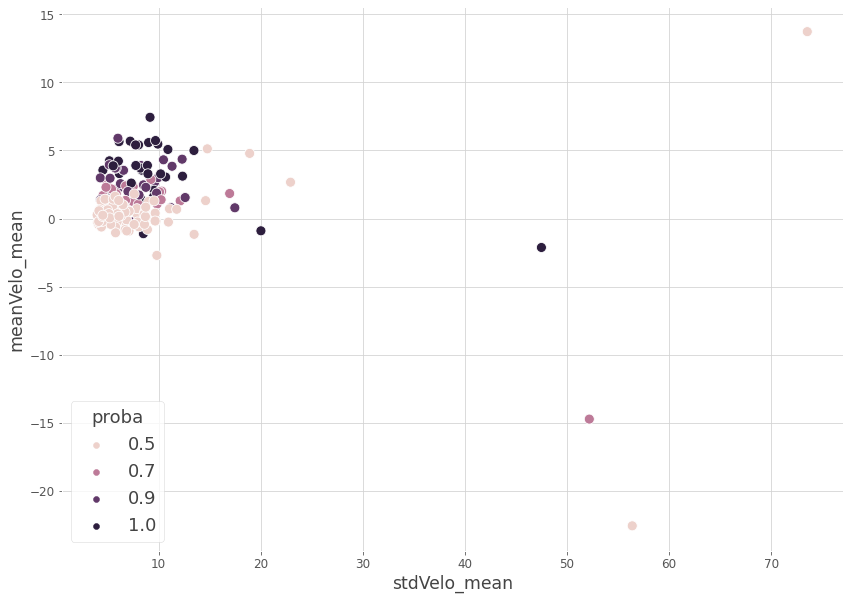

In [319]:
sns.scatterplot(data=df,x='stdVelo_mean' ,y='meanVelo_mean',s=100,hue='proba')

<AxesSubplot: xlabel='proba', ylabel='meanVelo_mean'>

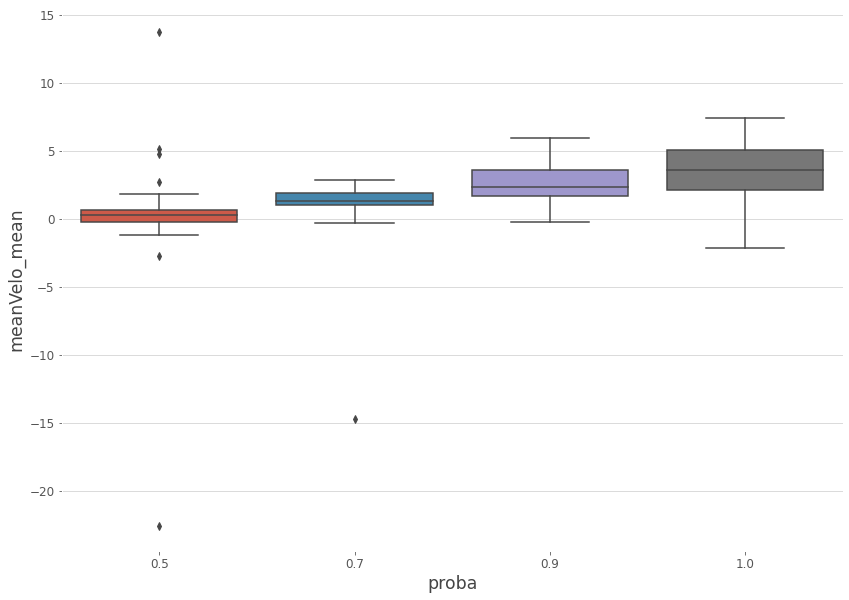

In [320]:
sns.boxplot(data=df,x='proba',y='meanVelo_mean')

In [ ]:
##Children

In [63]:
meanPosBias=[]
varPosBias=[]

meanPosNoBias=[]
varPosNoBias=[]

meanVeloBias=[]
varVeloBias=[]

meanVeloNoBias=[]
varVeloNoBias=[]

subjects=[]

Probas=[]

for f in allPaths[2]:
    data,bias,direct=read_asc(f)
    
    df=data["raw"]
    
    #Checking if the experiment was binorcular or monocular
    mono=data["info"]["mono"]
    #Putting all the data in the right format
    df['trial'] = pd.to_numeric(df['trial'], errors='coerce')
    df['time'] = pd.to_numeric(df['time'], errors='coerce')
    if not mono:
        df['xpl'] = pd.to_numeric(df['xpl'], errors='coerce')
        df['ypl'] = pd.to_numeric(df['ypl'], errors='coerce')
        df['psl'] = pd.to_numeric(df['psl'], errors='coerce')
        df['xpr'] = pd.to_numeric(df['xpr'], errors='coerce')
        df['ypr'] = pd.to_numeric(df['ypr'], errors='coerce')
        df['psr'] = pd.to_numeric(df['psr'], errors='coerce')
    else:
        df['xp'] = pd.to_numeric(df['xp'], errors='coerce')
        df['ypl'] = pd.to_numeric(df['yp'], errors='coerce')
        df['ps'] = pd.to_numeric(df['ps'], errors='coerce')

    df['input'] = pd.to_numeric(df['input'], errors='coerce')
    
    #Messages from eyelink:
    MSG=data["msg"]
    t0=MSG.loc[MSG.text=='StimulusOff\n','time']
    Zero=MSG.loc[MSG.text=='TargetOn\n',["trial","time"]]
    #resetting the time
    for i in range (len(Zero)):
        df.loc[df['trial'] == i+1, 'time'] = df.loc[df['trial'] == i+1, 'time'] - Zero.time.values[i]
    
    #Getting the saccades:
    Sacc=data["sacc"]
    #Resetting the saccades
    for t in Zero.trial:
        Sacc.loc[Sacc.trial==t,["stime","etime"]]=Sacc.loc[Sacc.trial==t,["stime","etime"]].values-Zero.loc[Zero.trial==t,'time'].values
  
    for t in Sacc.trial.unique():
    
        start=Sacc.loc[(Sacc.trial==t) & (Sacc.eye=="R"),"stime"]
        end=Sacc.loc[(Sacc.trial==t) & (Sacc.eye=="R"),"etime"]

    for i in range(len(start)):
        if not mono:
            df.loc[(df.trial==t) & (df.time>=start.iloc[i]-20) & (df.time<=end.iloc[i]+20),'xpr']=np.nan
        else:
             df.loc[(df.trial==t) & (df.time>=start.iloc[i]-20) & (df.time<=end.iloc[i]+20),'xp']=np.nan
    
    
    
    #Getting the probability from the name of the file
        proba=int(f[-6:-4])/100#probability
        if proba==0:
            proba=1
    
    #first porbability switch
    first_bias=np.where(bias==1)[0][0]+1
    
    
    if not mono:
        pos_non_bias=df.xpr[(df.time>=80) & (df.time<=120)& (df.trial<first_bias)]
        velo_non_bias=np.gradient(pos_non_bias)
        
        pos_bias=df.xpr[(df.time>=80) & (df.time<=120)& (df.trial>=first_bias)]
        velo_bias=np.gradient(pos_bias)
        
    else:
        pos_non_bias=df.xp[(df.time>=80) & (df.time<=120)& (df.trial<first_bias)]
        velo_non_bias=np.gradient(pos_non_bias)
        
        pos_bias=df.xp[(df.time>=80) & (df.time<=120)& (df.trial>=first_bias)]
        velo_bias=np.gradient(pos_bias)
    

    
 
    #mean pos on bias and non bias trials
    meanPosBias.append(np.mean(pos_bias))
    meanPosNoBias.append(np.mean(pos_non_bias))
    
    #variance of pos on bias and non bias trials
    varPosBias.append(np.var(pos_bias))
    varPosNoBias.append(np.var(pos_non_bias))
    
    #mean of velocity on bias and non bias trials
    meanVeloBias.append(np.mean(velo_bias))
    meanVeloNoBias.append(np.mean(velo_non_bias))
    
    #var of velocity on bias and non bias trials
    varVeloBias.append(np.var(velo_bias))
    varVeloNoBias.append(np.var(velo_non_bias))
    
    #subjects.append(name)
    
    Probas.append(proba)
    
    


(array([ 41.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  17.,
         24.,   0.,  10.,  72.,   0.,  41.,  41.,  31., 195., 357., 472.,
        467., 508., 565., 290., 302., 182.,  95., 126.,  52.,  48.,  10.,
         31.,   0.,   0.,   0.,   0.,  12.,  29.,   7.,  34.,   0.,  17.,
         24.,  14.,  27.,   0.,   1.,  40.]),
 array([ 716.6  ,  722.874,  729.148,  735.422,  741.696,  747.97 ,
         754.244,  760.518,  766.792,  773.066,  779.34 ,  785.614,
         791.888,  798.162,  804.436,  810.71 ,  816.984,  823.258,
         829.532,  835.806,  842.08 ,  848.354,  854.628,  860.902,
         867.176,  873.45 ,  879.724,  885.998,  892.272,  898.546,
         904.82 ,  911.094,  917.368,  923.642,  929.916,  936.19 ,
         942.464,  948.738,  955.012,  961.286,  967.56 ,  973.834,
         980.108,  986.382,  992.656,  998.93 , 1005.204, 1011.478,
        1017.752, 1024.026, 1030.3  ]),
 <BarContainer object of 50 artists>)

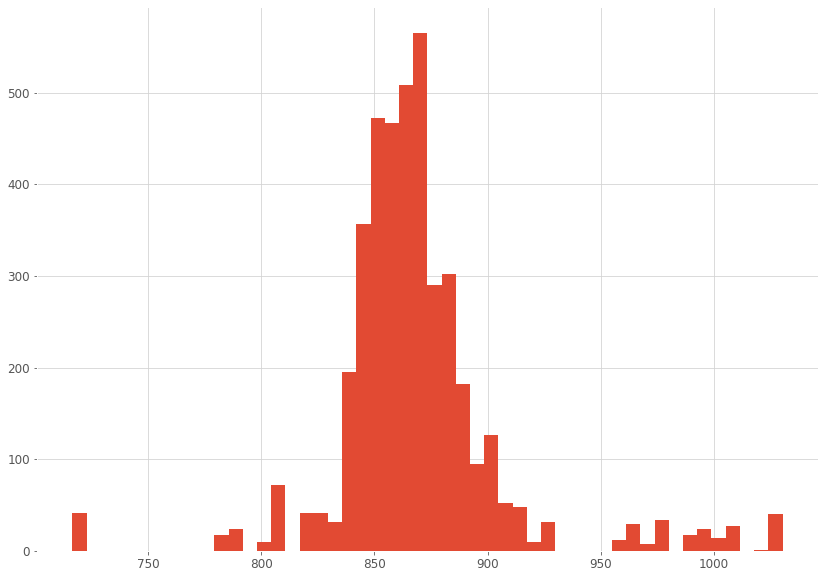

In [146]:
plt.hist(pos_bias,bins=50)

In [142]:
len(pos_bias)

4182

<AxesSubplot: xlabel='varPos', ylabel='mean_pos'>

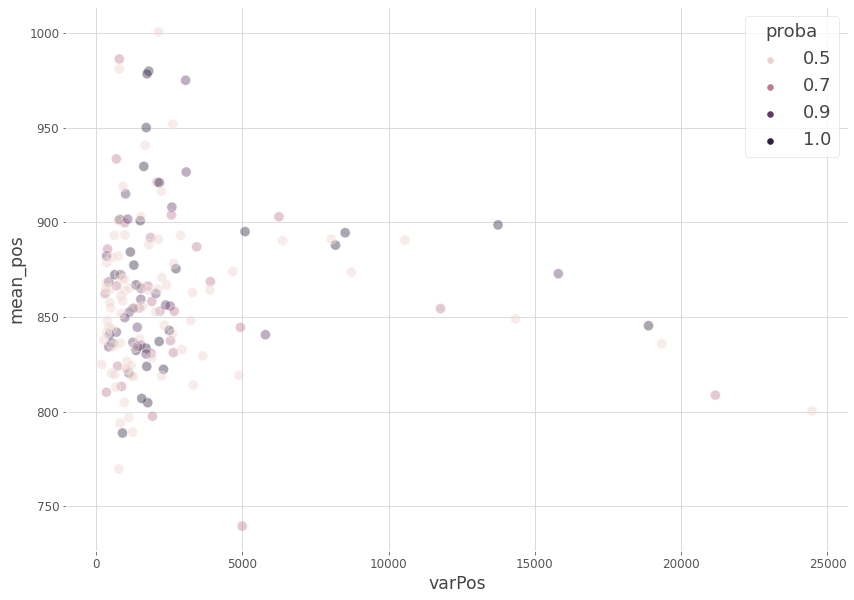

In [91]:
dfBias= pd.DataFrame({"mean_pos": meanPosBias,"varPos": varPosBias,'CV':np.sqrt(np.array(varPosBias))/np.array(meanPosBias) ,"proba": Probas})
dfNoBias= pd.DataFrame({"mean_pos": meanPosNoBias,"varPos": varPosNoBias,'CV':np.sqrt(np.array(varPosNoBias))/np.array(meanPosNoBias), "proba": [.5]*len(meanPosNoBias)})
df=pd.concat([dfBias,dfNoBias],axis=0)
sns.scatterplot(data=df,x="varPos",y="mean_pos",hue="proba",s=100,alpha=0.4)


<AxesSubplot: xlabel='CV', ylabel='mean_pos'>

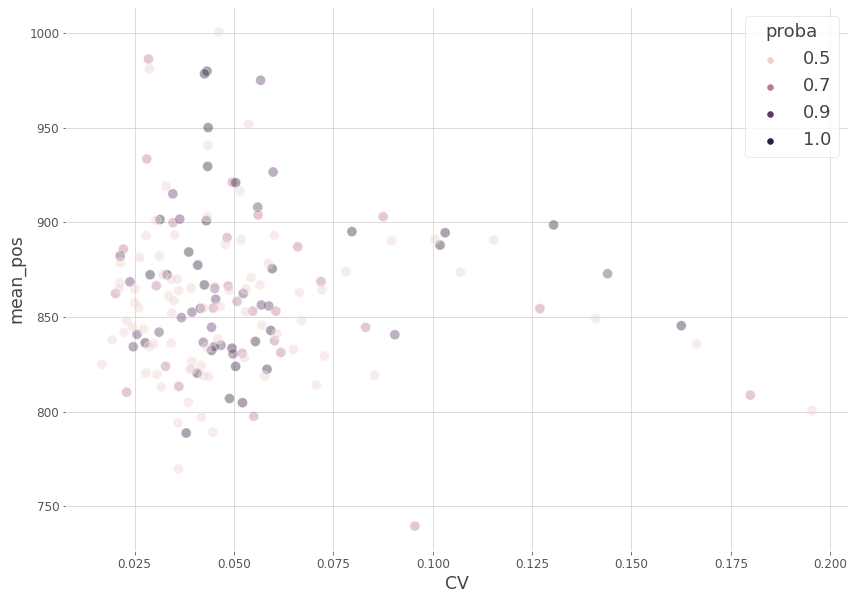

In [92]:
sns.scatterplot(data=df,x="CV",y="mean_pos",hue="proba",s=100,alpha=0.4)

<AxesSubplot: xlabel='mean_pos', ylabel='CV'>

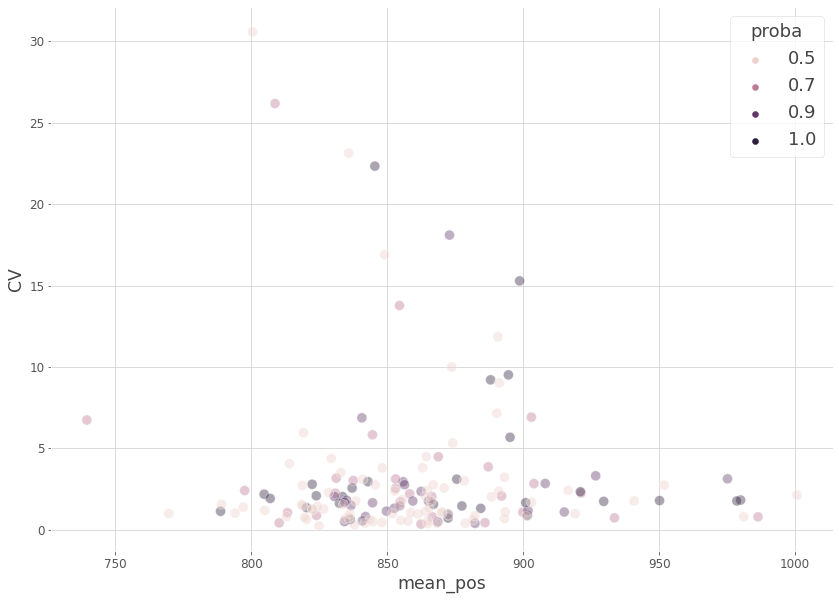

In [66]:
sns.scatterplot(data=df,x='mean_pos',y="CV",hue="proba",s=100,alpha=0.4)

In [111]:
subjects=[]
for name,file in zip (namesCat[2],allFiles[2]):
    for i in range(len(file)):
        subjects.append(name)

In [112]:
namesCat[2]

array(['ALBR', 'ALCH', 'ANAR', 'ANCH', 'ARBA', 'CHGA', 'DOLU', 'EKPE',
       'ELRO', 'ETGA', 'GAGI', 'GALA', 'JEFE', 'JOBA', 'JUBO', 'JUPA',
       'MAJO', 'MAPA2', 'NIBO', 'PAGA', 'PAMA2', 'ROGI', 'SOHE', 'TACH',
       'THBO', 'TOWA', 'ULBA', 'VIIB', 'VIIO'], dtype='<U5')

In [113]:
df["name"]=subjects*2

In [114]:
df

,mean_velo,stdvelo,CV,proba,name
0,0.008212,7.816283,951.797490,0.7,ALBR
1,0.016894,5.211213,308.462414,1.0,ALBR
2,NaN,NaN,NaN,0.9,ALCH
3,NaN,NaN,NaN,0.7,ALCH
4,NaN,NaN,NaN,1.0,ALCH
...,...,...,...,...,...
77,-0.007680,3.908904,-508.949832,0.5,VIIB
78,-0.034785,2.237115,-64.312374,0.5,VIIB
79,-0.012914,8.188066,-634.057310,0.5,VIIO
80,0.018412,6.096384,331.115392,0.5,VIIO


In [104]:
m=df.groupby("proba").mean()
m

,mean_velo,stdvelo,CV
proba,,,
0.5,-0.001349,5.675092,159.136495
0.7,0.008375,5.094335,94.336443
0.9,0.000666,6.466804,669.292435
1.0,0.008190,5.604688,2668.631015


In [105]:
sns.lmplot(m,x="mean_pos",y="CV")

KeyError: "['mean_pos'] not in index"

<AxesSubplot: xlabel='stdvelo', ylabel='mean_velo'>

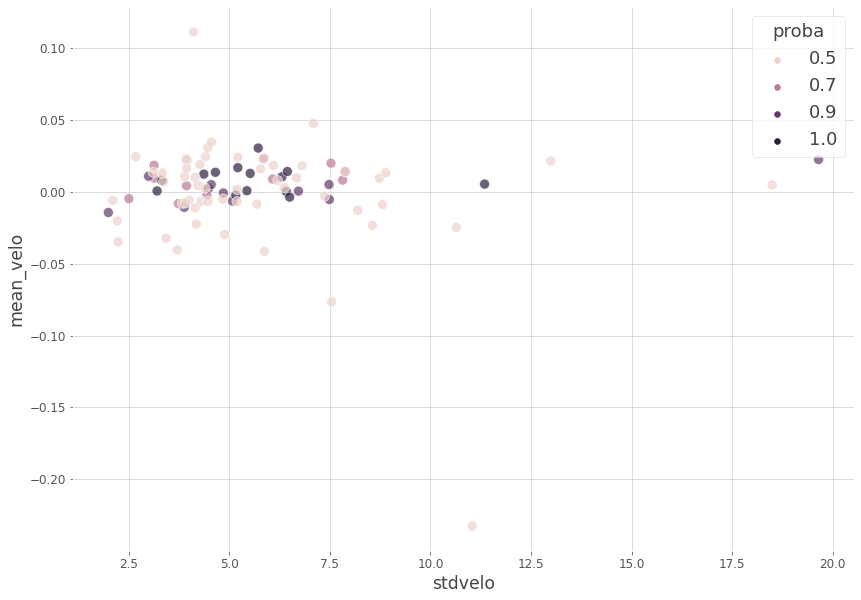

In [106]:
dfBias= pd.DataFrame({"mean_velo": meanVeloBias,"stdvelo": np.sqrt(np.array(varVeloBias)),'CV':np.sqrt(np.array(varVeloBias))/np.array(meanVeloBias) ,"proba": Probas})
dfNoBias= pd.DataFrame({"mean_velo": meanVeloNoBias,"stdvelo": np.sqrt(np.array(varVeloNoBias)),'CV':np.sqrt(np.array(varVeloNoBias))/np.array(meanVeloNoBias), "proba": [.5]*len(meanPosNoBias)})
df=pd.concat([dfBias,dfNoBias],axis=0)
sns.scatterplot(data=df,x="stdvelo",y="mean_velo",hue="proba",s=100,alpha=0.7)

In [107]:
m=df.groupby(["proba","name"]).mean()
m

KeyError: 'name'

In [108]:
m.reset_index(inplace=True)

In [109]:
m

,proba,mean_velo,stdvelo,CV
0,0.5,-0.001349,5.675092,159.136495
1,0.7,0.008375,5.094335,94.336443
2,0.9,0.000666,6.466804,669.292435
3,1.0,0.008190,5.604688,2668.631015


<AxesSubplot: xlabel='proba', ylabel='mean_velo'>

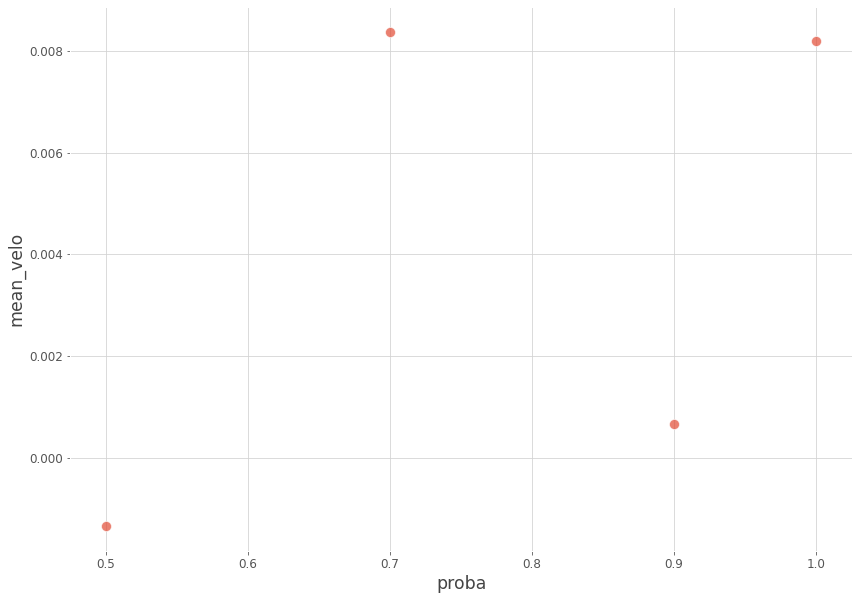

In [110]:
sns.scatterplot(data=m,x="proba",y="mean_velo",s=100,alpha=0.7)

In [138]:
posBias

NameError: name 'posBias' is not defined